<a href="https://colab.research.google.com/github/Ankush169/ELL887_Image_Processing/blob/main/image_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm

In [ ]:
# Set the device to GPU if available, otherwise use CPU
global device
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Define the Variational Autoencoder (VAE) class
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(1, -1),
            nn.Linear(64*8*8, self.latent_dim),
        )

        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1,(64,8,8)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
      # Forward pass through encoder and decoder
      x = self.encoder(x)
      x = self.decoder(x)
      return x

    @torch.no_grad
    def generate_image(self, x):
      # Generate an image using the trained VAE
      x = self.encoder(x)
      noise = torch.tensor(np.random.uniform(low=-1, high=1, size=x.shape).astype(np.float32) * (0.1 ** 8)).to(device)
      x = x + noise
      x = self.decoder(x)
      return x.detach().cpu().numpy()

# Instantiate the VAE, define loss function, and set up optimizer
vae = VAE(100).to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)

In [ ]:
# Training function for the VAE
def train_vae(X, y):
  output = vae.forward(X)
  loss = loss_fn(output, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.detach().cpu().numpy()

In [ ]:
# Load and preprocess CIFAR-10 dataset
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_dataset = datasets.CIFAR10('./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=128, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 34374928.07it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Extract images from the dataset
images = []
for img, label in cifar10_dataset:
  images.append(img.numpy())

images = np.array(images)

In [ ]:
# Training loop
num_epochs = 5000
mini_batch_size = 64

losses = []

for epoch in tqdm(range(num_epochs)):
  # make the mini-batch size
  batch_idx_list = np.random.choice(images.shape[0], mini_batch_size, replace=False)
  input_imgs = images[batch_idx_list]
  true_imgs = input_imgs.copy()

  input_imgs = torch.tensor(input_imgs).to(device)
  true_imgs = torch.tensor(true_imgs).to(device)

  epoch_loss = train_vae(input_imgs, true_imgs)
  losses.append(epoch_loss)

100%|██████████| 5000/5000 [00:32<00:00, 155.21it/s]


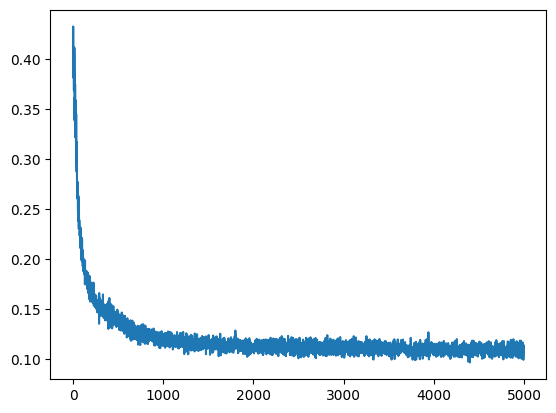

In [ ]:
# Plot the training losses
import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
# Visualize original and generated images
image_idx = 1000

orig_img = np.expand_dims(images[image_idx], 0)
new_img = vae.generate_image(torch.tensor(orig_img).to(device))

orig_img = np.squeeze(orig_img)
orig_img = np.transpose(orig_img, (1,2,0))

new_img = np.squeeze(new_img)
new_img = np.transpose(new_img, (1,2,0))

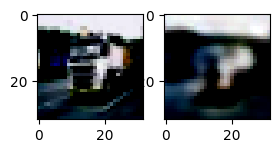

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(1*1 * 3, 1*2 * 3))
axes[0].imshow(orig_img)
axes[1].imshow(new_img)

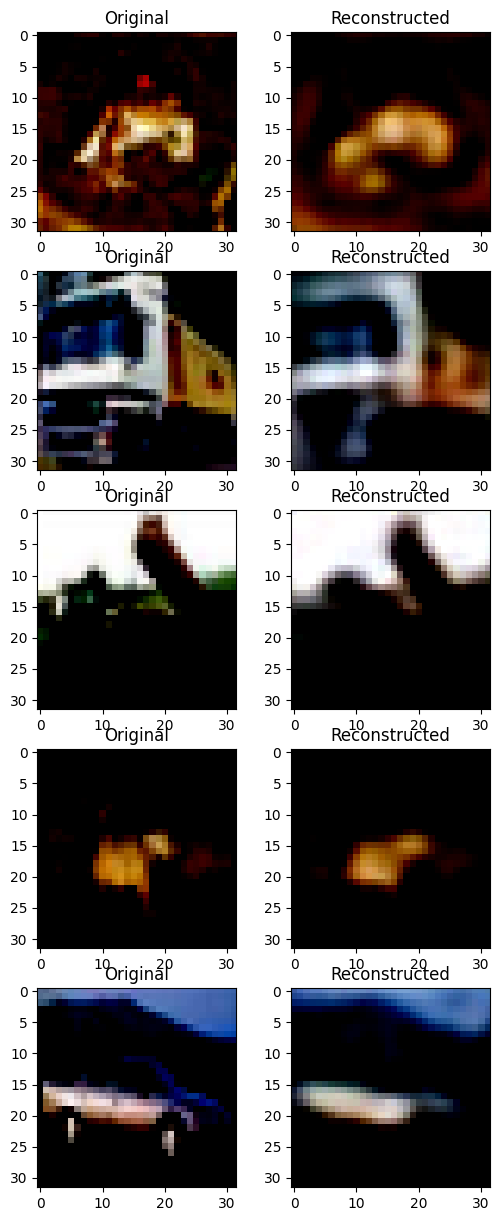

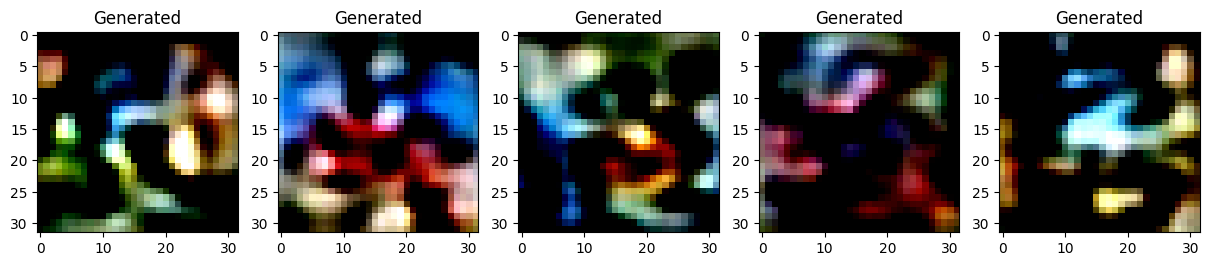

In [ ]:
# Additional visualizations: original vs reconstructed images and randomly generated images

num_visualize = 5
fig, axes = plt.subplots(num_visualize, 2, figsize=(2 * 3, num_visualize * 3))

for i in range(num_visualize):

    original_img = images[i]
    axes[i, 0].imshow(np.transpose(original_img, (1, 2, 0)))
    axes[i, 0].set_title("Original")


    input_img = torch.tensor(np.expand_dims(original_img, 0)).to(device)
    reconstructed_img = vae.forward(input_img)
    reconstructed_img = reconstructed_img.detach().cpu().numpy()
    reconstructed_img = np.squeeze(reconstructed_img)
    axes[i, 1].imshow(np.transpose(reconstructed_img, (1, 2, 0)))
    axes[i, 1].set_title("Reconstructed")

plt.show()


num_generate = 5
fig, axes = plt.subplots(1, num_generate, figsize=(num_generate * 3, 3))

for i in range(num_generate):

    random_input = torch.randn((1, 100)).to(device)
    generated_img = vae.decoder(random_input)
    generated_img = generated_img.detach().cpu().numpy()
    generated_img = np.squeeze(generated_img)
    axes[i].imshow(np.transpose(generated_img, (1, 2, 0)))
    axes[i].set_title("Generated")

plt.show()
